{download}`Download this notebook <1_algebraic_connectivity.ipynb>`

## Spectral optimization (alebraic congnectivity)
> **Main `gradnet` concepts demonstrated below**
> - Configuring a `GradNet` model for network optimization
> - Custom **loss function**
> - Training the network structure using `fit`
> - Accelerator selection (**cpu/gpu**)
> - **Learning rate** selection
> - Extracting and visualizing the optimized networks
> - Converting to **NetworkX**
> - Using a **mask** to ignore forbidden edges (e.g., grid)  

### Problem setup
The second Laplacian eigenvalue is a quantitative measure of connectivity and robustness. It indicates how “tightly held together” a network is, governs how fast diffusion converges on it, and reveals natural partitions in its structure.

### GradNet optimization

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/10000 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10000` reached.


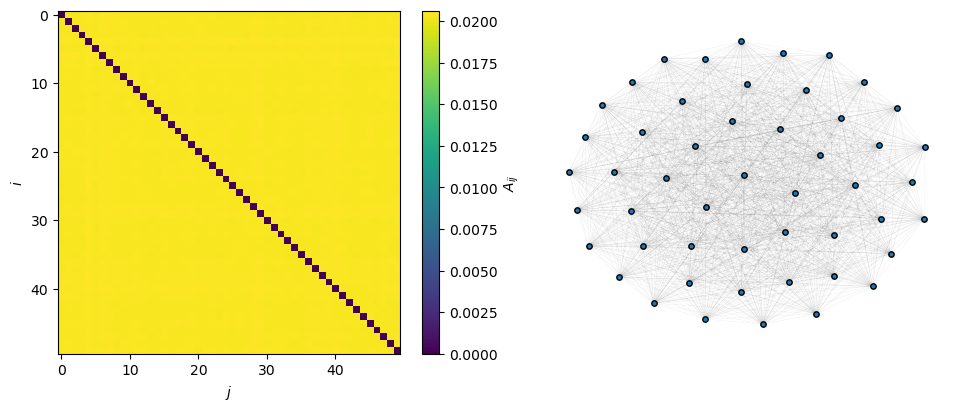

In [5]:
from gradnet import GradNet
from gradnet.trainer import fit
import torch
from matplotlib import pyplot as plt
from gradnet.utils import plot_adjacency_heatmap, plot_graph
import tensorboard


N = 50
budget_per_node = 1.0

gn = GradNet(num_nodes=N, budget=budget_per_node*N, rand_init_weights=True)

# define the loss function
def loss_fn(gn):
    A = gn()  # get the adjacency matrix
    L = torch.diag(A.sum(dim=1)) - A  # compute the graph Laplacian
    eigs = torch.linalg.eigvalsh(L)  # compute the eigenvalues
    l2 = eigs[1]  # second smallest eigenvalue (algebraic connectivity)
    # loss is (1-λ₂), so minimizing it maximizes λ₂. 
    return 1-l2  # return loss, and also λ₂ as a metric

lightning_trainer, best_ckpt = fit(gn=gn, loss_fn=loss_fn, num_updates=10000, optim_kwargs={"lr": 0.001}, accelerator="cpu");

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plot_adjacency_heatmap(gn, ax=ax0)
plot_graph(gn, ax=ax1)

We find that the uniform, conpletely connected graph is the optimal pattern for minimizing the resistance distance of the network.

### Restricting tunable edges to a grid

In [6]:
import numpy as np
import networkx as nx

rows = 30
cols = 30
N = rows * cols

def make_grid_mask(rows, cols):
    mask_nx = nx.grid_2d_graph(rows, cols)  # Build grid graph (nodes are (r, c) tuples)
    nodes = sorted(mask_nx.nodes())  # sort nodes
    return nx.to_numpy_array(mask_nx, nodelist=nodes)

mask = make_grid_mask(rows, cols)

gn_grid = GradNet(num_nodes=N, budget=budget_per_node * N, mask=mask, rand_init_weights=0.1)
lightning_trainer, best_ckpt = fit(gn=gn_grid, loss_fn=loss_fn, num_updates=100, optim_kwargs={"lr": 0.01}, accelerator="cpu");

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 810 K  | train
-----------------------------------------
810 K     Trainable params
0         Non-trainable params
810 K     Total params
3.240     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


/var/folders/72/79vqt54j447byqmvb80g_n3w0000gn/T/ipykernel_99761/52297011.py:13: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(net, pos=pos, ax=ax, edge_color=edge_weights, edge_cmap=plt.cm.viridis, width=3)


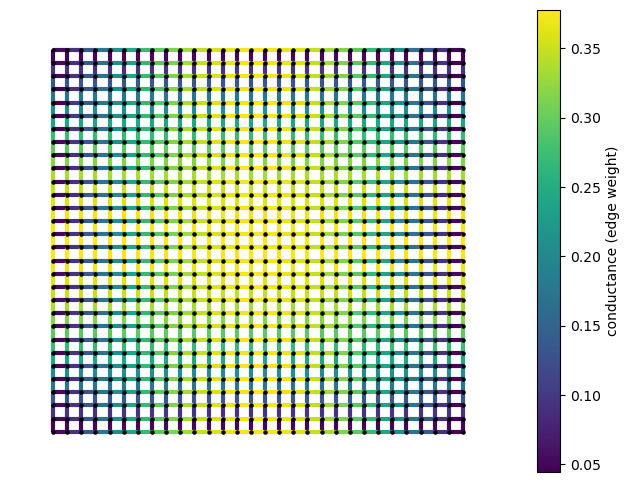

In [7]:
from gradnet.utils import to_networkx

net = to_networkx(gn_grid)

def draw_grid_graph(net):
    """Draw a grid graph with edges colored by their weights."""
    edge_weights = np.array(list(nx.get_edge_attributes(net, 'weight').values()))
    pos = {r * cols + c: (c, -r) for r in range(rows) for c in range(cols)}

    fig, ax = plt.subplots(figsize=(8, 6))  # Create figure and axis

    # Draw graph on the same axis
    nx.draw_networkx_edges(net, pos=pos, ax=ax, edge_color=edge_weights, edge_cmap=plt.cm.viridis, width=3)
    nx.draw_networkx_nodes(net, pos=pos, ax=ax, nodelist=sorted(net.nodes()), node_color="k", node_size=5)
    ax.set_axis_off()

    # Add colorbar linked to edges
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm.set_array(edge_weights)
    fig.colorbar(sm, ax=ax, label="conductance (edge weight)")

draw_grid_graph(net)
plt.show()

This indicates that, on a grid, edges near the center play a critical role and should be prioritized with more resources to enhance Algebraic Connectivity. At the periphery, edges matter differently: those aligned transversely to the boundary are significant, while those perpendicular to it contribute little importance.